### Exploratory Data Analysis - Bearing Data

This project uses sensor data collected from the Case Western Reserve University.  The website provides access to baseline (normal) and defect bearing sensor data.  The website can be found at the following URL location:

[Case Western Reserve University Bearing Data Site](https://csegroups.case.edu/bearingdatacenter/pages/welcome-case-western-reserve-university-bearing-data-center-website)

Experiments were conducted using a 2 hp Reliance Electric motor, and acceleration data was measured at locations near to and remote from the motor bearings using sensors. The following is a picture of what the machinery looks like:

![title](img/motorassembly.GIF)

Accelerometers were placed on the fan end and drive end of the motor as well as the base part of the motor.  Accelerometers were placed at the 12 o’clock position at both the drive end and fan end of the motor housing.  Outer raceway faults are stationary faults, therefore placement of the fault relative to the load zone of the bearing has a direct impact on the vibration response of the motor/bearing system. In order to quantify this effect, experiments were conducted for both fan and drive end bearings with outer raceway faults located at 3 o’clock (directly in the load zone), at 6 o’clock (orthogonal to the load zone), and at 12 o’clock.  Vibration signals were collected using a 16 channel DAT recorder, and were post processed in a Matlab format (CSEGROUP).   Vibration data was collected for both inner and outer raceways for both drive end and fan end parts of the motor.  For this project, only inner raceway data was used.  The following image shows the inner raceway of a SKF bearing

![title](img/bearinginfo.GIF)

The files which were used for this project include baseline data and bearing fault data collected for the inner raceway of the drive end of the machinery.  

![title](img/bearingmetadata.GIF)

The files were read into a numpy array and classified.  Sensor data was segmented into signals of sample size 256.  All of the last segment of each file which were less than 256 bytes were ignored.  Here are the stats.

NOTE:  EDM = Electro-discharge machining.  Faults were created using EDM.


In [62]:
# -*- coding: utf-8 -*-
"""
Created on Mon Dec 16 11:03:28 2019

@author: Paul Scheibal

This program is part of data acquisition and EDA.  A few signals from the sensor data of bearing
monitoring using an accelerometer are plotted.  FFT is then used to decompose the signals back
to their original amplitudes and frequeencies.  Power Spectoral Desnity and 
Autocorrellation is performed as well.  These will be used for feature engineering

"""

import pandas as pd
import numpy as np

import os.path

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl
import pylab as plb
import matplotlib.mlab as mlab

from math import trunc
from scipy.fftpack import fft,fftfreq,ifft,fftshift
from scipy.signal import welch
import scipy.io

from IPython.core.pylabtools import figsize
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

PATH_DATA = 'data\\'

# create segments 
def create_segments(arr,size,label):
    number_of_segments = int(trunc(len(arr)/size))
    features = [[] for x in range(number_of_segments)] 
    labels = [0 for x in range(number_of_segments)]
    for i in range(0,number_of_segments):
        istart = i*size
        iend = (i+1) * size
        segment_arr = list(arr[istart : iend])
        features[i] = segment_arr
        labels[i] = label
    return features, labels


# Reads a datafile of vibration data and puts it into a dataframe       
def get_data(path,filef,prefix,rpm):
    mat = scipy.io.loadmat(path+filef)
    DEcol = prefix + '_DE_time'
    arrDE_time = mat[DEcol]
    valRPM = rpm
    arrDE_time = arrDE_time[:,0]
    df = pd.DataFrame()
    df['DriveEnd_TS'] = arrDE_time
    df['RPM'] = valRPM
    return df
    
# reads all files and puts them into features and labels
def create_model_inputs(path,flst,fnlst,rpmlst,labellst,segment_size):
    df_temp = pd.DataFrame()
    features_lst = []
    labels_lst = []
    for i in range(0,len(flst)):
        df_temp = get_data(path,flst[i],fnlst[i],rpmlst[i])
        features_temp,labels_temp = create_segments(df_temp.DriveEnd_TS,segment_size,label=labellst[i])
        labels_lst = labels_lst + labels_temp
        features_lst = features_lst + features_temp
    features_arr = np.array(features_lst)
    labels_arr = np.array(labels_lst)
    return features_arr, labels_arr

def plot_segment(x,y,ttl, xlab, ylab):
    figsize(13,6)
    fig, ax = plt.subplots()
    plt.plot(x,y)
    plt.title(ttl, fontsize=16)
    plt.ylabel(ylab, fontsize=16)
    plt.xlabel(xlab, fontsize=16)
    plt.grid(True)
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
    plt.show()

# baseline meta data
baseline_file = ['97.mat','98.mat','99.mat','100.mat']
baseline_name = ['X097','X098','X099','X100']
baseline_label = [0,1,2,3]
baseline_rpm = [1797,1772,1750,1730]

# fault meta data
fault_file = ['105.mat','169.mat','209.mat','3001.mat','106.mat','170.mat','210.mat','3002.mat','107.mat','171.mat','211.mat','3003.mat','108.mat','172.mat','212.mat','3004.mat']
fault_name = ['X105','X169','X209','X056','X106','X170','X210','X057','X107','X171','X211','X058','X108','X172','X212','X059']
fault_label = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
fault_rpm = [1797,1797,1797,1797,1772,1772,1772,1772,1750,1750,1750,1750,1730,1730,1730,1730]

# combine baseline and fault metadata into one
input_file = baseline_file + fault_file
input_file_name = baseline_name + fault_name
input_label = baseline_label + fault_label
input_rpm = baseline_rpm + fault_rpm
segment_size = 256
# read data and create features and labels
feature_input, label_input = create_model_inputs(PATH_DATA,input_file,input_file_name,input_rpm,input_label,segment_size)

# segment size is 256
samples = 256
samples_per_sec = 12000
time = samples/samples_per_sec
sample_interval = time / samples
freq_high = int(samples_per_sec/2)

dfli = pd.DataFrame()
dfli['labels'] = label_input
cnts = dfli.labels.value_counts().reset_index(drop=False)
cnts.columns=['label#','labels']

print('\n')
print('Segment Size:', samples)
print('\n')
print('Total Number of Segments:', cnts.labels.sum())
print('\n')
print('Segments per Label:')
print('\n')
print(cnts.sort_values('label#').reset_index(drop=True))



Segment Size: 256


Total Number of Segments: 14234


Segments per Label:


    label#  labels
0        0     952
1        1    1890
2        2    1894
3        3    1897
4        4     473
5        5     475
6        6     477
7        7     471
8        8     476
9        9     475
10      10     474
11      11     474
12      12     477
13      13     475
14      14     475
15      15     474
16      16     480
17      17     475
18      18     476
19      19     474


The following are two baselines signals:

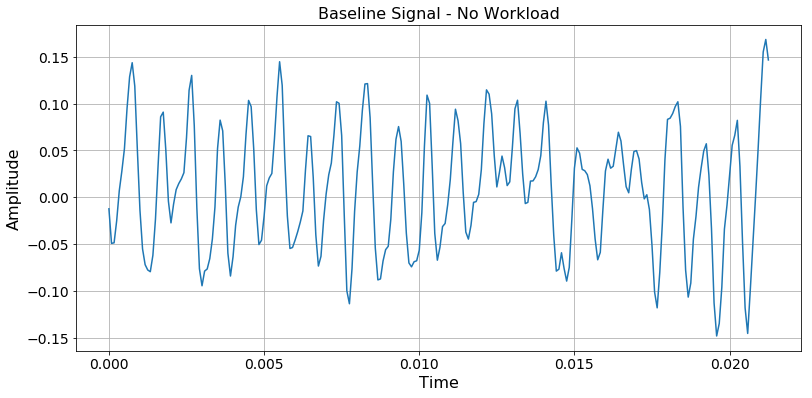

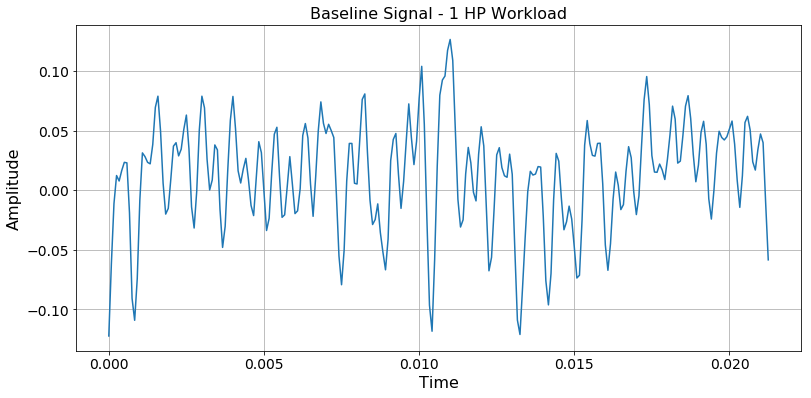

In [63]:
t = np.arange(0,time,sample_interval)
f = np.arange(0,freq_high,1/time)

y = feature_input[15,:]
plot_segment(t,y,'Baseline Signal - No Workload','Time','Amplitude')
y = feature_input[1000,:]
plot_segment(t,y,'Baseline Signal - 1 HP Workload','Time','Amplitude')

The following four signals have defective ball bearings of 0, 1, 2 and 3 HP workloads and .007, .014, .021 and .028 inches EDM.

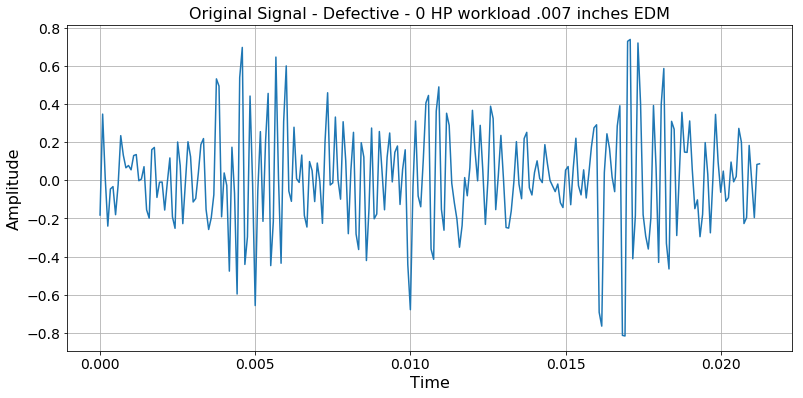

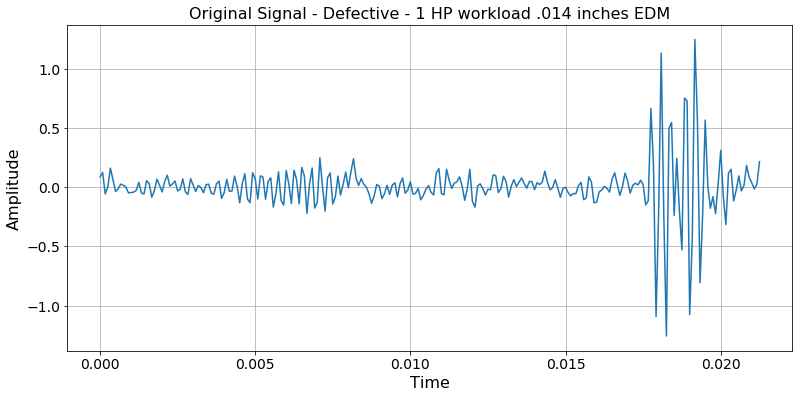

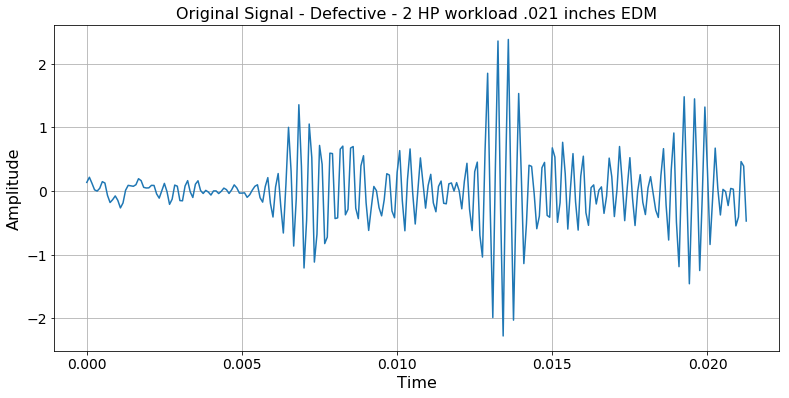

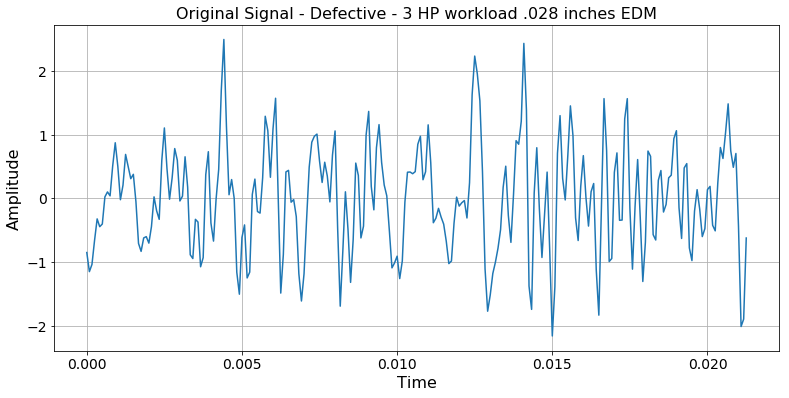

In [64]:
y = feature_input[6650,:]
plot_segment(t,y,'Original Signal - Defective - 0 HP workload .007 inches EDM','Time','Amplitude')
y = feature_input[9100,:]
plot_segment(t,y,'Original Signal - Defective - 1 HP workload .014 inches EDM','Time','Amplitude')
y = feature_input[11500,:]
plot_segment(t,y,'Original Signal - Defective - 2 HP workload .021 inches EDM','Time','Amplitude')
y = feature_input[13800,:]
plot_segment(t,y,'Original Signal - Defective - 3 HP workload .028 inches EDM','Time','Amplitude')

# Engineered Features using FFT and DWT

This project consists of creating a model using One-Dimensional Convolutional Neural Networks using the raw sensor signals as input to the model and creating engineered features using Fast Fourier Transform (FFT) and Discrete Wavelet Transform (DWT).  This section focuses on showing the engineered features of FFT and DWT.

### FFT Engineered Features

FFT uses the positive peaks of the frequency domain amplitudes and power spectral density and the positive peaks of the autocorrelation of the signal as follows:

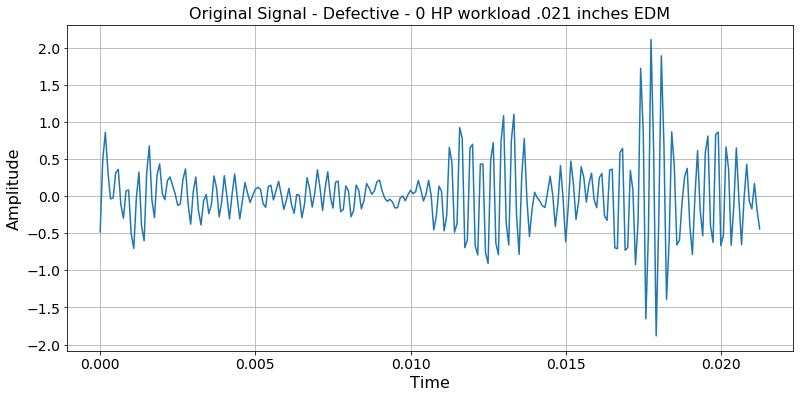

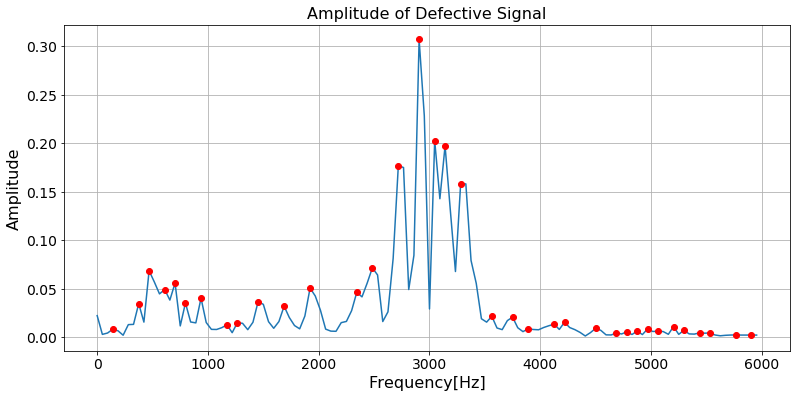

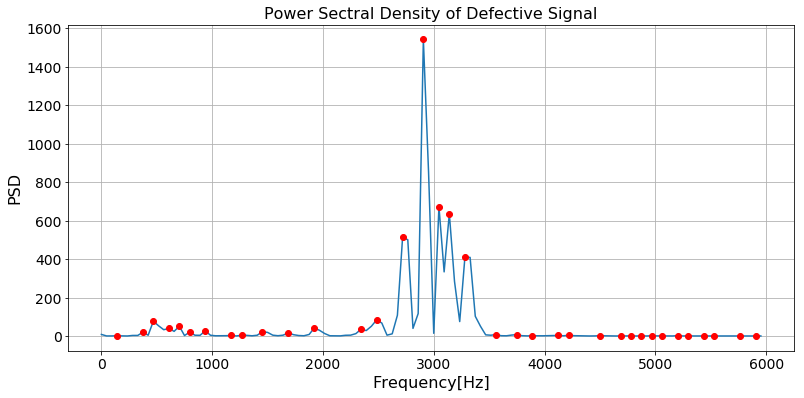

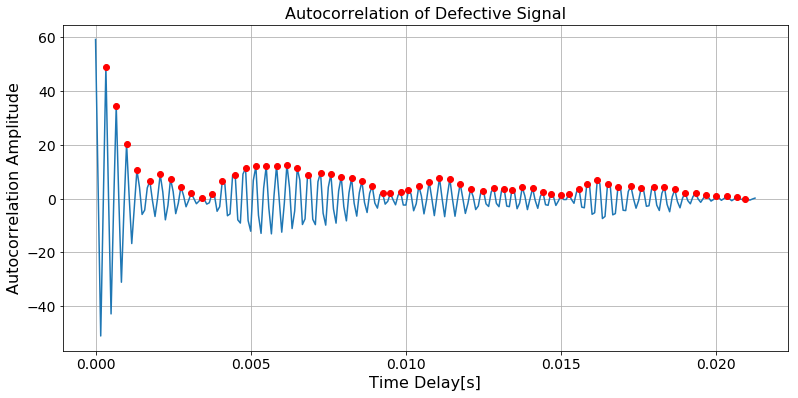

True

In [65]:
# Copied From http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
# Thank you Marcos Duarte.  I copied it from Taspinar's site.

def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.
    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).
    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.
    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 
    See this IPython Notebook [1]_.
    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)
    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)
    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)
    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)
    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)
    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind
 
# calculate frequency spectrum and power spectrum density
def calc_fft(y, samples, time):
    fft_vector = fft(y)
    fft_amp = 2.0/samples * np.abs(fft_vector[0:samples])
    fft_psd = np.abs(fft_vector[0:samples]) ** 2
    freqarr = fftfreq(samples,time / samples)
    samplefreqarr = freqarr
    i = np.where(freqarr >= 0)
    samplefreqarr = freqarr[i]
    fft_psd = fft_psd[i]
    fft_amp = fft_amp[i]
    return fft_amp, fft_psd, samplefreqarr[0:samples//2]
 
# auto correlation
def calc_autocorr(y, sample_interval, samples):
    autocorr_vector = np.correlate(y, y, mode='full')
    autocorr_vector = autocorr_vector[len(autocorr_vector)//2:]
    x_autocorr = np.array([sample_interval * i for i in range(0, len(autocorr_vector))])
    return x_autocorr, autocorr_vector

# plotting function
def plot_fft(x,y,ttl,xlab,ylab,plot_type,incr,peaks):
    fig, ax = plt.subplots()
    if plot_type == 'stem':
        plt.stem(x,y,markerfmt='C3o',linefmt='C0-')
    else:
        plt.plot(x, y, linestyle='-', color='C0')
        plt.plot(x[peaks], y[peaks], linestyle='none', color='red', marker='.',markersize=12)
    plt.xlabel(xlab, fontsize=16)
    plt.ylabel(ylab, fontsize=16)
    plt.title(ttl, fontsize=16)
    plt.grid(True)
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
    plt.show()
    return True

# get fft vectors
y = feature_input[8000,:]
plot_segment(t,y,'Original Signal - Defective - 0 HP workload .021 inches EDM','Time','Amplitude')
amp_vector, psd_vector, samplefreqarr = calc_fft(y,samples,time)

# plot data with signal peaks.  Peak information will be used for feature extraction for fft results
peaks = detect_peaks(amp_vector)
plot_fft(samplefreqarr, amp_vector,'Amplitude of Defective Signal','Frequency[Hz]','Amplitude','plot',1,peaks)

peaks = detect_peaks(psd_vector)
plot_fft(samplefreqarr, psd_vector,'Power Sectral Density of Defective Signal','Frequency[Hz]','PSD','plot',1,peaks)

t_values, autocorr_vector = calc_autocorr(y, sample_interval, samples)
peaks = detect_peaks(autocorr_vector)
plot_fft(t_values, autocorr_vector,'Autocorrelation of Defective Signal','Time Delay[s]','Autocorrelation Amplitude','plot',0.1,peaks)

As you can see with the red dots, each of these represent potential engineered featuress.  In this case it is a defective signal.  Only the top 10 peaks of each of the three above plots are retained as features for this project.

### DWT Engineered Features

The Discrete Wavelet Transform provides information on a signal in both the frequency and time domain.  High and low pass filter banks collect information about the signal at each level in the process.  The python function pywt.wavedec() returns the final set of coefficients for the low frequency result and all of the high frequency sets of coefficients for the results at each level.  This information is then fed into three functions which calculate entropy, statistics and crossings on each of the sets of coefficients.

Entropy is a measure of uncertainty or randomness of a distribution in machine learning and is defined as follows:![title](img/entropy.GIF)


The entropy calculation is as follows:

    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities) or -sum(probabilities * np.log(probabilities))

The statistical features that are calculated on the sets of coefficients returned by pywt.wavedec() are as follows:

    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    
    Note:  the nan prefix tells the function to ignore nan values.

The final set of features is the number of times the signal crosses the x axis at y = 0 and the number of times the signal crosses the x axis at y = mean(signal_values).  The calculation is as follows:

    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    print(no_zero_crossings, no_mean_crossings)

The wavelet used for this processing is 'sym2'


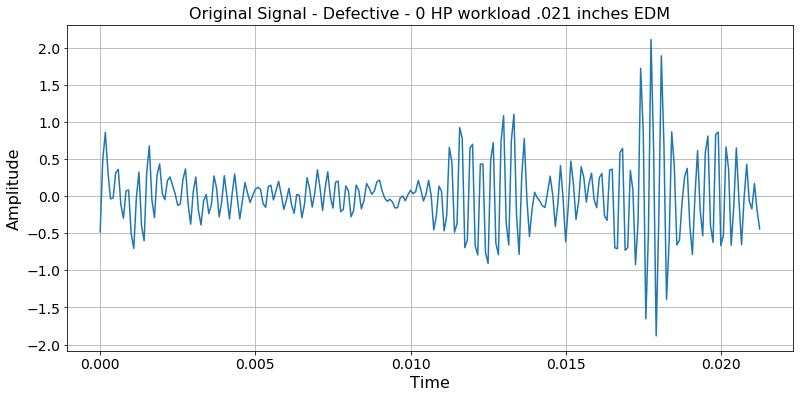

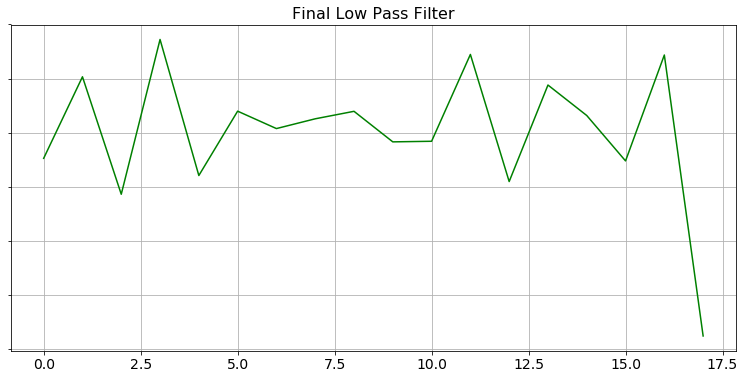

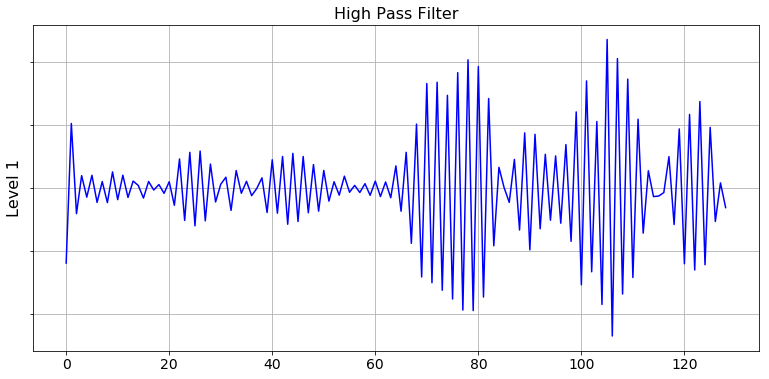

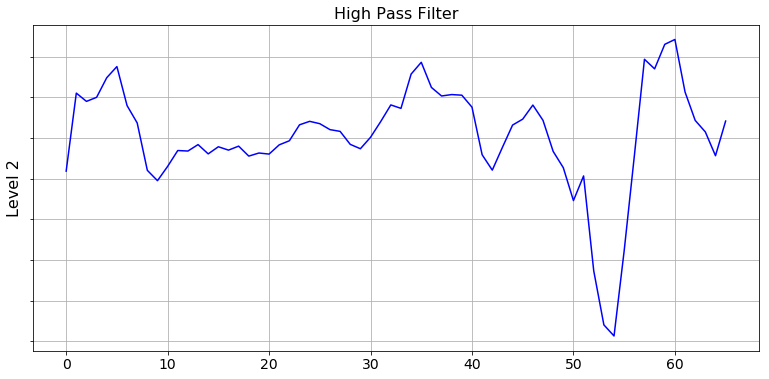

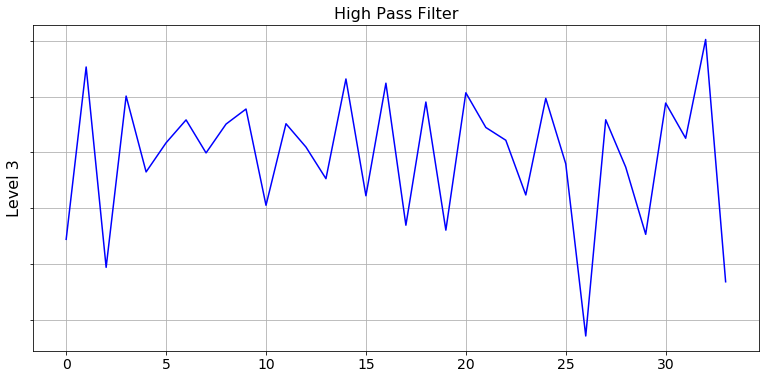

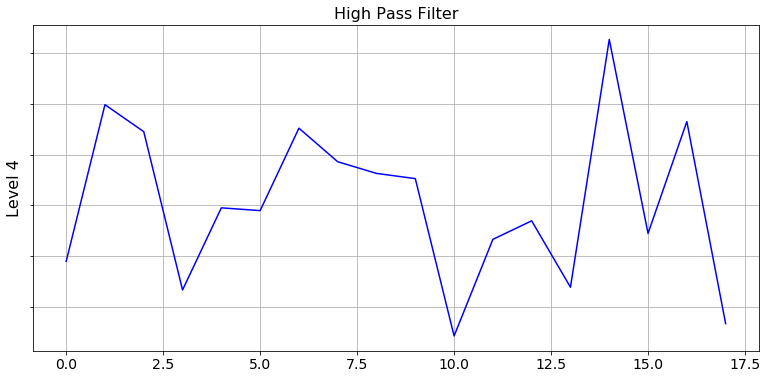

Number of Features Extracted from Entropy, Statistics and Crossings: 60


Feature input from Entropy, Statistics and Crossings...


[ 2.89037176e+00  1.20000000e+01  1.20000000e+01 -3.05573686e-01
 -1.01549385e-01  1.52173128e-01  2.97584820e-01  3.35453457e-02
  8.47779535e-04  2.44079037e-01  5.95745762e-02  1.76271953e-01
  2.89037176e+00  8.00000000e+00  8.00000000e+00 -4.71644866e-01
 -1.98121732e-01  2.60647183e-01  4.34845700e-01 -1.47219084e-02
  1.07439907e-02  3.07125548e-01  9.43261022e-02  2.53358114e-01
  3.52636052e+00  2.40000000e+01  2.20000000e+01 -4.30937625e-01
 -1.55134447e-01  1.71528999e-01  2.78377682e-01  3.88027490e-02
 -1.24981417e-02  2.37068851e-01  5.62016400e-02  1.90071560e-01
  4.18965474e+00  1.10000000e+01  1.10000000e+01 -1.23351982e+00
 -1.97591599e-01  4.06325966e-01  9.18140411e-01  7.78957681e-02
  2.60163183e-02  6.60753742e-01  4.36595508e-01  4.57942965e-01
  4.85981240e+00  1.22000000e+02  1.22000000e+02 -8.30951635e-01
 -2.56190717e-01  2.307

In [66]:
import pywt
from collections import defaultdict, Counter
#
#  These routines were used from Ahmet Taspinar's github site for extraction
#  of features using dwt.
#
# Copyright (c) 2016 by Ahmet Taspinar (taspinar@gmail.com)
#

def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    pk = probabilities
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics
#
# modified by Paul Scheibal for bearing data input
#
def extract_dwt_features(signal, waveletname,level=3):
    features = []
    list_coeff = pywt.wavedec(signal, waveletname,level=level)
    for coeff in list_coeff:
        features += get_features(coeff)
    X = np.array(features)
    return X

#
#  End of Ahmet Taspinar's functions
#  of features using dwt.

dwt_levels = 4
waveletname = 'sym2'
plot_segment(t,y,'Original Signal - Defective - 0 HP workload .021 inches EDM','Time','Amplitude')

coef = pywt.wavedec(y,waveletname,level=dwt_levels)

fig, ax = plt.subplots()
plt.plot(coef[0],color='green')
plt.title('Final Low Pass Filter', fontsize=16)
ax.set_yticklabels([])
plt.grid(True)
for tick in ax.get_xticklabels():
    tick.set_fontsize(14)
for tick in ax.get_yticklabels():
    tick.set_fontsize(14)
plt.show()

for i in range(1,len(coef)):
    fig, ax = plt.subplots()
    j = len(coef) - i
    plt.plot(coef[j],color='blue')
    plt.title('High Pass Filter', fontsize=16)
    plt.ylabel('Level ' + str(i), fontsize=16)
    ax.set_yticklabels([])
    plt.grid(True)
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
    plt.show()

X = extract_dwt_features(y, waveletname,dwt_levels)

print('Number of Features Extracted from Entropy, Statistics and Crossings:', len(X))
print('\n')
print('Feature input from Entropy, Statistics and Crossings...')
print('\n')
print(X)

# Conclusion

Feature extraction is a powerful tool for machine learning and tends to be domain specific.  The features we have created using FFT and DWT will be used to predict faults in bearing sensor data.